# 데이터 전처리

In [1]:
import sqlite3
import pandas as pd
import numpy as np

In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
from plotnine import *
import plotnine

In [4]:
from sklearn.preprocessing import MinMaxScaler
from kmodes.kprototypes import KPrototypes

In [5]:
from tqdm import tqdm_notebook
from tqdm import tqdm
import time
from ipypb import ipb

In [6]:
# 경고 메세지 안보이게 설정
import warnings
warnings.filterwarnings('ignore')

In [7]:
from scipy.stats import mode

## 분석할 테이블 불러오기

In [8]:
# 1번 + 2번 + 4번 연결
con = sqlite3.connect("lpoint.db", isolation_level=None) # lpoint db 생성 or 연결


data = pd.read_sql('''
SELECT P.cust, D.ma_fem_dv, D.ages, D.zon_hlv, P.rct_no, P.de_dt, P.chnl_dv, P.cop_c, P.pd_c, C.clac_hlv_nm, C.clac_mcls_nm, C.pd_nm, P.de_hr, P.buy_am, P.buy_ct
FROM PDDE AS P, DEMO AS D, PD_CLAC AS C
WHERE P.cust = D.cust AND P.pd_c = C.pd_c
GROUP BY P.cust, D.ma_fem_dv, D.ages, D.zon_hlv, P.rct_no, P.de_dt, P.chnl_dv, P.cop_c, P.pd_c, C.clac_hlv_nm, C.clac_mcls_nm, C.pd_nm, P.de_hr, P.buy_am, P.buy_ct;
''', con, index_col=None)

con.close()

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4144389 entries, 0 to 4144388
Data columns (total 17 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   고객번호      object
 1   성별        object
 2   연령대       object
 3   거주지분류대코드  object
 4   영수증번호     object
 5   구매일자      int64 
 6   채널구분      int64 
 7   제휴사       object
 8   상품코드      object
 9   상품대분류명    object
 10  상품중분류명    object
 11  상품소분류명    object
 12  구매시간      int64 
 13  구매금액      int64 
 14  구매수량      int64 
 15  구매월       object
 16  구매계절      object
dtypes: int64(5), object(12)
memory usage: 537.5+ MB


In [9]:
# 불러온 테이블 컬럼명 한글로 재설정
data.columns = ['고객번호', '성별', '연령대', '거주지분류대코드', '영수증번호', '구매일자', '채널구분', '제휴사', 
                '상품코드', '상품대분류명', '상품중분류명', '상품소분류명',
                '구매시간', '구매금액', '구매수량']

## 구매계절 변수 추가

In [10]:
data['구매월'] = data['구매일자'].map(lambda x: str(x)[4:6]+'월')

data.loc[(data['구매월']=='03월') | (data['구매월']=='04월') | (data['구매월']=='05월'), '구매계절'] = '봄'
data.loc[(data['구매월']=='06월') | (data['구매월']=='07월') | (data['구매월']=='08월'), '구매계절'] = '여름'
data.loc[(data['구매월']=='09월') | (data['구매월']=='10월') | (data['구매월']=='11월'), '구매계절'] = '가을'
data.loc[(data['구매월']=='12월') | (data['구매월']=='01월') | (data['구매월']=='02월'), '구매계절'] = '겨울'

# 고객코드 중복 처리

In [12]:
# 상품소분류명 최빈값 -> 그 상품의 대분류명으로 매핑을 위해 pd_calc 테이블 불러오기
con = sqlite3.connect("lpoint.db", isolation_level=None) # lpoint db 생성 or 연결


# pd_clac 테이블, 데이터프레임에 저장
con = sqlite3.connect("lpoint.db", isolation_level=None)
pd_clac = pd.read_sql("SELECT * FROM PD_CLAC", con, index_col=None)

In [13]:
item = pd_clac[['pd_nm', 'clac_hlv_nm']]
item

,pd_nm,clac_hlv_nm
0,소파,가구
1,스툴/리빙의자,가구
2,탁자,가구
3,장식장/진열장,가구
4,기타가구,가구
...,...,...
1928,여성향수,화장품/뷰티케어
1929,남성향수,화장품/뷰티케어
1930,남녀공용향수,화장품/뷰티케어
1931,남성향수세트,화장품/뷰티케어


In [14]:
# 군집화 수행할 변수 선택
df = data[['고객번호', '성별', '연령대', '거주지분류대코드', '채널구분', '상품소분류명', '구매시간', '구매금액', '구매계절']]
df.head()

,고객번호,성별,연령대,거주지분류대코드,채널구분,상품소분류명,구매시간,구매금액,구매계절
0,M000034966,여성,40대,Z07,1,남성런닝/트레이닝화,18,19000,겨울
1,M000034966,여성,40대,Z07,1,남성런닝/트레이닝화,18,59000,겨울
2,M000034966,여성,40대,Z07,1,스포츠아대/헤어밴드,18,100,겨울
3,M000034966,여성,40대,Z07,1,여성런닝/트레이닝화,18,62100,겨울
4,M000034966,여성,40대,Z07,1,남성팬티,13,5000,봄


# 성별 여성인것만

In [15]:
df = df[df['성별'] == '여성']

In [16]:
# 고객번호의 종류 개수
print("고객번호 종류 개수:", len(df['고객번호'].unique()))

고객번호 종류 개수: 18485


In [17]:
# 중복처리된 데이터 담을 변수 생성
newdf = df.drop_duplicates(['고객번호'], keep='first', ignore_index=True)

In [18]:
# 채널구분 - 평균값
newdf[['고객번호', '채널구분']] = df.groupby('고객번호')['채널구분'].mean().reset_index()
newdf.loc[newdf['채널구분'] <= 1.5, '채널구분'] = 1 # 평균이 1.5라면 오프라인으로 구분(오프라인이 다수이기 때문)
newdf.loc[newdf['채널구분'] > 1.5, '채널구분'] = 2
# object 타입으로 변경해주기
newdf['채널구분'] = newdf['채널구분'].map(lambda x:str(int(x))+'번')

In [19]:
# 상품소분류명 - 최빈값
newdf[['고객번호', '상품소분류명']] = df.groupby('고객번호')['상품소분류명'].agg(**{'상품소분류명':lambda x:x.mode()[0]}).reset_index()

In [20]:
# 구매시간 - 평균값
newdf[['고객번호', '구매시간']] = df.groupby('고객번호')['구매시간'].agg(**{'구매시간':lambda x:round(x.mean())}).reset_index()

In [21]:
# 구매금액 - 중앙값
newdf[['고객번호', '구매금액']] = df.groupby('고객번호')['구매금액'].agg(**{'구매금액':lambda x:round(x.median())}).reset_index()

In [22]:
# 구매계절 - 최빈값
newdf[['고객번호', '구매계절']] = df.groupby('고객번호')['구매계절'].agg(**{'구매계절':lambda x:x.mode()[0]}).reset_index()

In [23]:
newdf.head()

,고객번호,성별,연령대,거주지분류대코드,채널구분,상품소분류명,구매시간,구매금액,구매계절
0,M000034966,여성,40대,Z07,1번,가공조미료,17,4970,가을
1,M000136117,여성,30대,Z11,1번,여성기타모피의류,15,53500,겨울
2,M000201112,여성,50대,Z17,1번,삼각김밥,12,1700,여름
3,M000225114,여성,40대,Z17,1번,일반스낵,17,5500,봄
4,M000261625,여성,40대,Z17,1번,디저트,15,46500,여름


In [24]:
# 상품대분류명은 소분류명에 해당된 대분류로 매핑
newdf['상품대분류명'] = newdf['상품소분류명'].values
before = list(newdf['상품대분류명'].values)
after = []

In [25]:
for i in tqdm(before):
    after.append(item[item['pd_nm'] == i]['clac_hlv_nm'].values[0])

100%|██████████████████████████████████████████████████████████████████████████| 18485/18485 [00:14<00:00, 1257.28it/s]


In [26]:
newdf['상품대분류명'].replace(before, after, inplace=True) # 2분 정도 기다려야 함

In [27]:
newdf.head()

,고객번호,성별,연령대,거주지분류대코드,채널구분,상품소분류명,구매시간,구매금액,구매계절,상품대분류명
0,M000034966,여성,40대,Z07,1번,가공조미료,17,4970,가을,조미료
1,M000136117,여성,30대,Z11,1번,여성기타모피의류,15,53500,겨울,여성의류
2,M000201112,여성,50대,Z17,1번,삼각김밥,12,1700,여름,조리식품
3,M000225114,여성,40대,Z17,1번,일반스낵,17,5500,봄,과자
4,M000261625,여성,40대,Z17,1번,디저트,15,46500,여름,테넌트/음식점


In [28]:
newdf.tail()

,고객번호,성별,연령대,거주지분류대코드,채널구분,상품소분류명,구매시간,구매금액,구매계절,상품대분류명
18480,M999492154,여성,20대,Z10,1번,기타남성의류세트,14,17400,가을,남성의류
18481,M999599111,여성,40대,Z04,1번,국산담배,18,7230,봄,담배
18482,M999770689,여성,30대,Z16,1번,바초콜릿,13,2300,여름,과자
18483,M999849895,여성,20대,Z04,1번,임대매출,16,7600,가을,기타(비상품)
18484,M999962961,여성,50대,Z17,1번,냉동튀김,16,5960,여름,냉동식품


In [29]:
newdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18485 entries, 0 to 18484
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   고객번호      18485 non-null  object
 1   성별        18485 non-null  object
 2   연령대       18485 non-null  object
 3   거주지분류대코드  18485 non-null  object
 4   채널구분      18485 non-null  object
 5   상품소분류명    18485 non-null  object
 6   구매시간      18485 non-null  int64 
 7   구매금액      18485 non-null  int64 
 8   구매계절      18485 non-null  object
 9   상품대분류명    18485 non-null  object
dtypes: int64(2), object(8)
memory usage: 1.4+ MB


# 군집화

## 스케일링 X

In [30]:
ndf1 = newdf.drop(['고객번호', '상품소분류명'], axis=1)

In [31]:
# Categorical 변수 정해주기
catcol = [ndf1.columns.get_loc(col) for col in list(ndf1.select_dtypes('object').columns)]
print('Categorical columns {}'.format(list(ndf1.select_dtypes('object').columns)))
print('Categorical columns position : {}'.format(catcol))

Categorical columns ['성별', '연령대', '거주지분류대코드', '채널구분', '구매계절', '상품대분류명']
Categorical columns position : [0, 1, 2, 3, 6, 7]


In [32]:
dfmatrix1 = ndf1.to_numpy()
dfmatrix1

array([['여성', '40대', 'Z07', ..., 4970, '가을', '조미료'],
       ['여성', '30대', 'Z11', ..., 53500, '겨울', '여성의류'],
       ['여성', '50대', 'Z17', ..., 1700, '여름', '조리식품'],
       ...,
       ['여성', '30대', 'Z16', ..., 2300, '여름', '과자'],
       ['여성', '20대', 'Z04', ..., 7600, '가을', '기타(비상품)'],
       ['여성', '50대', 'Z17', ..., 5960, '여름', '냉동식품']], dtype=object)

### 군집화

In [33]:
## Kprototypes 군집분석
cost = []
for cluster in ipb(range(1, 7)):
    try:
        kprototype = KPrototypes(n_clusters = cluster, init = 'Huang',
                                 random_state = 0, verbose = True)
        kprototype.fit_predict(dfmatrix1, categorical = catcol)
        cost.append(kprototype.cost_)
        print('Cluster initiation: {}'.format(cluster))
    except:
        break
    time.sleep(0.1)

 [████████████████████████████████████████████████████████████] 6/6 [40:06<11:53, 401.01s/it]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 0, ncost: 101130811767711.62
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 0, ncost: 101130811767711.62
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 0, ncost: 101130811767711.62
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 4, iteration: 1/100, moves: 0, ncost: 101130811767711.62
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 5, iteration: 1/100, moves: 0, ncost: 101130811767711.62
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 6, iteration: 1/100, moves: 0, ncost: 101130811767711.62
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 7, iteration: 1/100, moves: 0, ncost: 101130811767711.62
Init: 

Run: 9, iteration: 7/100, moves: 9, ncost: 49606009920086.65
Run: 9, iteration: 8/100, moves: 7, ncost: 49259354208467.51
Run: 9, iteration: 9/100, moves: 3, ncost: 49109035827083.46
Run: 9, iteration: 10/100, moves: 4, ncost: 48986803326194.48
Run: 9, iteration: 11/100, moves: 0, ncost: 48986803326194.48
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 10, iteration: 1/100, moves: 360, ncost: 60406140586330.08
Run: 10, iteration: 2/100, moves: 143, ncost: 56498765530578.31
Run: 10, iteration: 3/100, moves: 64, ncost: 54378564254157.1
Run: 10, iteration: 4/100, moves: 42, ncost: 52374514563268.266
Run: 10, iteration: 5/100, moves: 33, ncost: 50327081729794.88
Run: 10, iteration: 6/100, moves: 9, ncost: 49606009920086.65
Run: 10, iteration: 7/100, moves: 7, ncost: 49259354208467.51
Run: 10, iteration: 8/100, moves: 3, ncost: 49109035827083.46
Run: 10, iteration: 9/100, moves: 4, ncost: 489868033

Run: 8, iteration: 10/100, moves: 5, ncost: 27879873921448.83
Run: 8, iteration: 11/100, moves: 0, ncost: 27879873921448.83
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 9, iteration: 1/100, moves: 11990, ncost: 55673893262158.51
Run: 9, iteration: 2/100, moves: 2608, ncost: 47500143698607.83
Run: 9, iteration: 3/100, moves: 1063, ncost: 40115668797028.914
Run: 9, iteration: 4/100, moves: 646, ncost: 34660015956779.332
Run: 9, iteration: 5/100, moves: 330, ncost: 30891371396278.516
Run: 9, iteration: 6/100, moves: 213, ncost: 28556974939701.88
Run: 9, iteration: 7/100, moves: 116, ncost: 28028701900439.79
Run: 9, iteration: 8/100, moves: 42, ncost: 27910007691581.617
Run: 9, iteration: 9/100, moves: 22, ncost: 2788255429063

Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 4, iteration: 1/100, moves: 1158, ncost: 47176801647059.36
Run: 4, iteration: 2/100, moves: 486, ncost: 36229500963867.43
Run: 4, iteration: 3/100, moves: 528, ncost: 28722292301544.312
Run: 4, iteration: 4/100, moves: 532, ncost: 23086471872960.99
Run: 4, iteration: 5/100, moves: 485, ncost: 21918414028230.55
Run: 4, iteration: 6/100, moves: 334, ncost: 21677105763957.344
Run: 4, iteration: 7/100, moves: 206, ncost: 21586250452670.35
Run: 4, iteration: 8/100, moves: 121, ncost: 21538632284557.777
Run: 4, iteration: 9/100, moves: 135, ncost: 21485927314271.297
Run: 4, iteration: 10/100, moves: 91, ncost: 21454687534013.21
Run: 4, iteration: 11/100, moves: 45, ncost: 21438310228233.14
Run: 4, iteration: 12/100, moves: 41, ncost: 21363384806360.86
Run: 4, iteration: 13/100, moves: 19, ncost: 21123968974732.348
Run: 4, iteration: 14/100, moves: 56, 

Starting iterations...
Run: 8, iteration: 1/100, moves: 2233, ncost: 55905182370636.84
Run: 8, iteration: 2/100, moves: 1344, ncost: 45322448447765.35
Run: 8, iteration: 3/100, moves: 1218, ncost: 34968791816680.523
Run: 8, iteration: 4/100, moves: 837, ncost: 28277454433315.207
Run: 8, iteration: 5/100, moves: 575, ncost: 23145108944496.17
Run: 8, iteration: 6/100, moves: 540, ncost: 21935241948553.766
Run: 8, iteration: 7/100, moves: 330, ncost: 21683925337706.07
Run: 8, iteration: 8/100, moves: 223, ncost: 21592032245863.594
Run: 8, iteration: 9/100, moves: 126, ncost: 21539121860228.15
Run: 8, iteration: 10/100, moves: 133, ncost: 21487241395692.723
Run: 8, iteration: 11/100, moves: 91, ncost: 21455402950907.49
Run: 8, iteration: 12/100, moves: 50, ncost: 21438310228233.14
Run: 8, iteration: 13/100, moves: 41, ncost: 21363384806360.86
Run: 8, iteration: 14/100, moves: 19, ncost: 21123968974732.348
Run: 8, iteration: 15/100, moves: 56, ncost: 20116116881073.4
Run: 8, iteration: 16/1

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 5809, ncost: 42573371906226.55
Run: 2, iteration: 2/100, moves: 1527, ncost: 30550340349463.816
Run: 2, iteration: 3/100, moves: 1050, ncost: 23328936724571.492
Run: 2, iteration: 4/100, moves: 875, ncost: 20063912926826.887
Run: 2, iteration: 5/100, moves: 659, ncost: 19338170968908.457
Run: 2, iteration: 6/100, moves: 368, ncost: 19046436481074.61
Run: 2, iteration: 7/100, moves: 269, ncost: 18222186755564.055
Run: 2, iteration: 8/100, moves: 250, ncost: 15933261018366.182
Run: 2, iteration: 9/100, moves: 276, ncost: 12819277470573.793
Run: 2, iteration: 10/100, moves: 339, ncost: 10252069513076.863
Run: 2, iteration: 11/100, moves: 207, ncost: 9004794826554.873
Run: 2, iteration: 12/100, moves: 178, ncost: 8630049819235.122
Run: 2, iteration: 13/100, moves: 184, ncost: 8545568256996.109
Run: 2, iteration: 14/100, moves: 165, ncost: 8507050236140.476
Run: 2, iteration: 15/

Run: 6, iteration: 16/100, moves: 29, ncost: 8493891309581.462
Run: 6, iteration: 17/100, moves: 10, ncost: 8493539105706.611
Run: 6, iteration: 18/100, moves: 35, ncost: 8491016520661.305
Run: 6, iteration: 19/100, moves: 16, ncost: 8490519730231.094
Run: 6, iteration: 20/100, moves: 9, ncost: 8490423243750.266
Run: 6, iteration: 21/100, moves: 9, ncost: 8490310777413.817
Run: 6, iteration: 22/100, moves: 1, ncost: 8490309544919.432
Run: 6, iteration: 23/100, moves: 0, ncost: 8490309544919.432
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializ

Run: 10, iteration: 4/100, moves: 293, ncost: 19197363820411.67
Run: 10, iteration: 5/100, moves: 269, ncost: 18419899322036.59
Run: 10, iteration: 6/100, moves: 275, ncost: 16256718044758.352
Run: 10, iteration: 7/100, moves: 265, ncost: 13127047577292.791
Run: 10, iteration: 8/100, moves: 376, ncost: 10275657971093.096
Run: 10, iteration: 9/100, moves: 245, ncost: 9019506835382.191
Run: 10, iteration: 10/100, moves: 185, ncost: 8644816043477.712
Run: 10, iteration: 11/100, moves: 188, ncost: 8546997135875.013
Run: 10, iteration: 12/100, moves: 171, ncost: 8507134498470.039
Run: 10, iteration: 13/100, moves: 52, ncost: 8499469185540.6045
Run: 10, iteration: 14/100, moves: 23, ncost: 8495016346082.872
Run: 10, iteration: 15/100, moves: 29, ncost: 8493891309581.462
Run: 10, iteration: 16/100, moves: 10, ncost: 8493539105706.611
Run: 10, iteration: 17/100, moves: 35, ncost: 8491016520661.305
Run: 10, iteration: 18/100, moves: 16, ncost: 8490519730231.094
Run: 10, iteration: 19/100, moves

Run: 3, iteration: 20/100, moves: 144, ncost: 6095448635282.452
Run: 3, iteration: 21/100, moves: 210, ncost: 5970568907501.628
Run: 3, iteration: 22/100, moves: 86, ncost: 5890334122366.991
Run: 3, iteration: 23/100, moves: 32, ncost: 5882825149062.915
Run: 3, iteration: 24/100, moves: 12, ncost: 5880171816986.202
Run: 3, iteration: 25/100, moves: 11, ncost: 5878092707350.408
Run: 3, iteration: 26/100, moves: 45, ncost: 5859476288195.418
Run: 3, iteration: 27/100, moves: 19, ncost: 5852205489930.593
Run: 3, iteration: 28/100, moves: 15, ncost: 5849719776104.962
Run: 3, iteration: 29/100, moves: 0, ncost: 5849719776104.962
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 4, iteration: 1/100, moves: 1611, ncost: 52511704538482.27
Run: 4, iteration: 2/100, moves: 971, ncost: 393265532

Run: 7, iteration: 18/100, moves: 144, ncost: 6095448635282.452
Run: 7, iteration: 19/100, moves: 210, ncost: 5970568907501.628
Run: 7, iteration: 20/100, moves: 86, ncost: 5890334122366.991
Run: 7, iteration: 21/100, moves: 32, ncost: 5882825149062.915
Run: 7, iteration: 22/100, moves: 12, ncost: 5880171816986.202
Run: 7, iteration: 23/100, moves: 11, ncost: 5878092707350.408
Run: 7, iteration: 24/100, moves: 45, ncost: 5859476288195.418
Run: 7, iteration: 25/100, moves: 19, ncost: 5852205489930.593
Run: 7, iteration: 26/100, moves: 15, ncost: 5849719776104.962
Run: 7, iteration: 27/100, moves: 0, ncost: 5849719776104.962
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroid

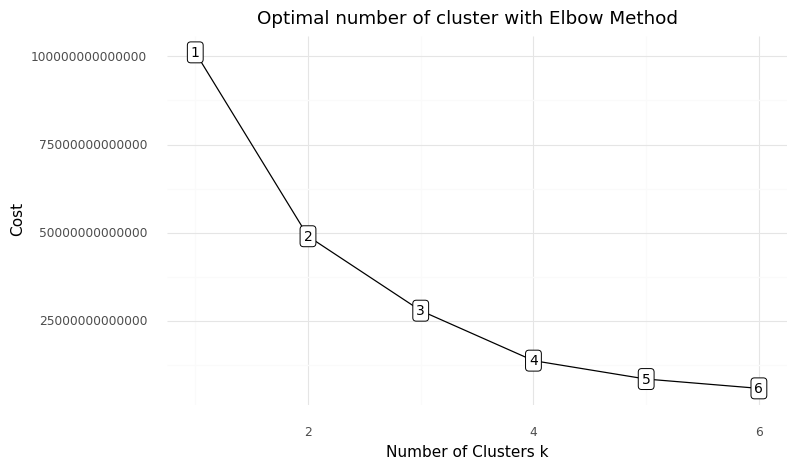

<ggplot: (144272046324)>

In [34]:
## 군집분석 결과 시각화
df_cost = pd.DataFrame({'Cluster':range(1, 7), 'Cost':cost})

plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_cost)+
    geom_line(aes(x = 'Cluster',
                  y = 'Cost'))+
    geom_point(aes(x = 'Cluster',
                   y = 'Cost'))+
    geom_label(aes(x = 'Cluster',
                   y = 'Cost',
                   label = 'Cluster'),
               size = 10,
               nudge_y = 1000) +
    labs(title = 'Optimal number of cluster with Elbow Method')+
    xlab('Number of Clusters k')+
    ylab('Cost')+
    theme_minimal()
)

cost가 너무 커서 군집화 시간도 오래걸리고 군집화에 문제가 있을 수 있다고 판단.

In [35]:
df_cost

,Cluster,Cost
0,1,1.011308e+14
1,2,4.898680e+13
2,3,2.787987e+13
3,4,1.371229e+13
4,5,8.490310e+12
5,6,5.849720e+12


In [36]:
## 성능 평가
from sklearn.metrics import silhouette_score

# Silhouette coefficient
print(silhouette_score(newdf['구매금액'].to_numpy().reshape(-1, 1), kprototype.labels_, metric='euclidean'))
print(silhouette_score(newdf['구매시간'].to_numpy().reshape(-1, 1), kprototype.labels_, metric='euclidean'))

0.8267542464846378
0.06659661790835404


범주형 변수 + 수치형 변수에 대해 군집하는 Kprototypes는 성능 평가 하기에 적합하지 않다.

## 스케일링 O

In [37]:
ndf2 = newdf.drop(['고객번호', '상품소분류명'], axis=1)

In [38]:
ndf2

,성별,연령대,거주지분류대코드,채널구분,구매시간,구매금액,구매계절,상품대분류명
0,여성,40대,Z07,1번,17,4970,가을,조미료
1,여성,30대,Z11,1번,15,53500,겨울,여성의류
2,여성,50대,Z17,1번,12,1700,여름,조리식품
3,여성,40대,Z17,1번,17,5500,봄,과자
4,여성,40대,Z17,1번,15,46500,여름,테넌트/음식점
...,...,...,...,...,...,...,...,...
18480,여성,20대,Z10,1번,14,17400,가을,남성의류
18481,여성,40대,Z04,1번,18,7230,봄,담배
18482,여성,30대,Z16,1번,13,2300,여름,과자
18483,여성,20대,Z04,1번,16,7600,가을,기타(비상품)


In [39]:
# Categorical 변수 정해주기
catcol = [ndf2.columns.get_loc(col) for col in list(ndf2.select_dtypes('object').columns)]
print('Categorical columns {}'.format(list(ndf2.select_dtypes('object').columns)))
print('Categorical columns position : {}'.format(catcol))

Categorical columns ['성별', '연령대', '거주지분류대코드', '채널구분', '구매계절', '상품대분류명']
Categorical columns position : [0, 1, 2, 3, 6, 7]


In [40]:
# Scaling
scaler = MinMaxScaler() 
scaler_fit = scaler.fit(ndf2[['구매시간', '구매금액']]) ## 각 칼럼 데이터마다 변환할 함수 생성
ndf2[['구매시간', '구매금액']] = scaler_fit.transform(ndf2[['구매시간', '구매금액']])

In [41]:
dfmatrix2 = ndf2.to_numpy()
dfmatrix2

array([['여성', '40대', 'Z07', ..., 0.0012298290360867698, '가을', '조미료'],
       ['여성', '30대', 'Z11', ..., 0.013485189019924746, '겨울', '여성의류'],
       ['여성', '50대', 'Z17', ..., 0.0004040506073385692, '여름', '조리식품'],
       ...,
       ['여성', '30대', 'Z16', ..., 0.0005555695850905326, '여름', '과자'],
       ['여성', '20대', 'Z04', ..., 0.001893987221899543, '가을', '기타(비상품)'],
       ['여성', '50대', 'Z17', ..., 0.0014798353493775097, '여름', '냉동식품']],
      dtype=object)

### 군집화

In [94]:
## Kprototypes 군집분석
cost = []
for cluster in ipb(range(1, 11)):
    try:
        kprototype = KPrototypes(n_clusters = cluster, init = 'Huang',
                                 random_state = 0, verbose = True)
        kprototype.fit_predict(dfmatrix2, categorical = catcol)
        cost.append(kprototype.cost_)
        print('Cluster initiation: {}'.format(cluster))
    except:
        break
    time.sleep(0.1)

 [████████████████████████████████████████████████████████████] 10/10 [13:53<02:12, 83.31s/it]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 0, ncost: 9782.147802425903
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 0, ncost: 9782.147802425903
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 0, ncost: 9782.147802425903
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 4, iteration: 1/100, moves: 0, ncost: 9782.147802425903
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 5, iteration: 1/100, moves: 0, ncost: 9782.147802425903
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 6, iteration: 1/100, moves: 0, ncost: 9782.147802425903
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 7, iteration: 1/100, moves: 0, ncost: 9782.147802425903
Init: initial

Run: 7, iteration: 2/100, moves: 22, ncost: 7614.13953334059
Run: 7, iteration: 3/100, moves: 5, ncost: 7614.13952942136
Run: 7, iteration: 4/100, moves: 0, ncost: 7614.13952942136
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 8, iteration: 1/100, moves: 5862, ncost: 7564.1886530688025
Run: 8, iteration: 2/100, moves: 216, ncost: 7564.186043068052
Run: 8, iteration: 3/100, moves: 0, ncost: 7564.186043068052
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 9, iteration: 1/100, moves: 4067, ncost: 7773.373539312978
Run: 9, iteration: 2/100, moves: 3471, ncost: 7651.047673623872
Run: 9, iteration: 3/100, moves: 1196, ncost: 7649.746366797686
Run: 9, iteration: 4/100, moves: 0, ncost: 7649.746366797686
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 10, iteration: 1/100, moves: 3172, ncost: 7464.363714526024
Run: 10, iteration: 2/100, moves: 2, ncost: 7464.363714508135
Run: 10, i

Run: 2, iteration: 5/100, moves: 2, ncost: 6970.778862375969
Run: 2, iteration: 6/100, moves: 0, ncost: 6970.778862375969
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 4647, ncost: 7137.435077118762
Run: 3, iteration: 2/100, moves: 267, ncost: 7137.424205314715
Run: 3, iteration: 3/100, moves: 2, ncost: 7137.424200234485
Run: 3, iteration: 4/100, moves: 0, ncost: 7137.424200234485
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 4, iteration: 1/100, moves: 5579, ncost: 6934.294851337428
Run: 4, iteration: 2/100, moves: 565, ncost: 6934.248685960344
Run: 4, iteration: 3/100, moves: 0, ncost: 6934.248685960344
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 5, iteration: 1/100, moves: 4654, ncost: 6975.620776459627
Run: 5, iteration: 2/100, moves: 1027, ncost: 6975.251088227387
Run: 5, iteration: 3/100, moves: 78, ncost: 6975.247856886943
Run: 5, ite

Starting iterations...
Run: 4, iteration: 1/100, moves: 5697, ncost: 6772.958813770221
Run: 4, iteration: 2/100, moves: 1798, ncost: 6771.692184918225
Run: 4, iteration: 3/100, moves: 453, ncost: 6771.607391032681
Run: 4, iteration: 4/100, moves: 22, ncost: 6771.607190417882
Run: 4, iteration: 5/100, moves: 2, ncost: 6771.607190326212
Run: 4, iteration: 6/100, moves: 0, ncost: 6771.607190326212
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 5, iteration: 1/100, moves: 4987, ncost: 6724.7675418840045
Run: 5, iteration: 2/100, moves: 1641, ncost: 6723.731646479414
Run: 5, iteration: 3/100, moves: 852, ncost: 6723.298948006215
Run: 5, iteration: 4/100, moves: 208, ncost: 6723.278071463783
Run: 5, iteration: 5/100, moves: 2, ncost: 6723.277468558012
Run: 5, iteration: 6/100, moves: 0, ncost: 6723.277468558012
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 6, iteration: 1/100, moves: 3832, ncost: 6976.514472143594
R

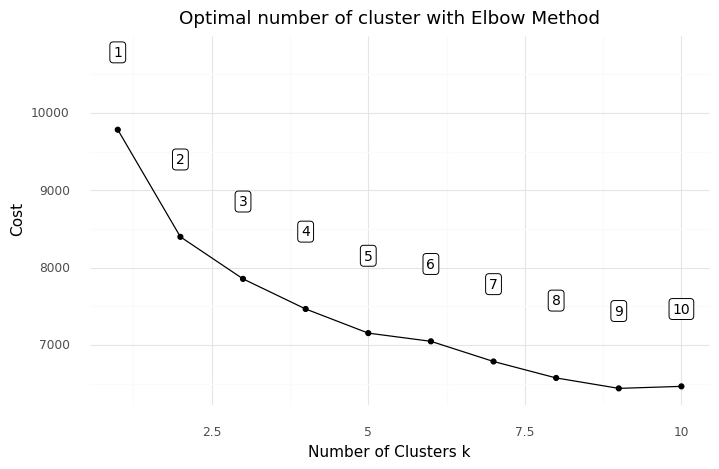

<ggplot: (144170508385)>

In [95]:
## 군집분석 결과 시각화
df_cost = pd.DataFrame({'Cluster':range(1, 11), 'Cost':cost})

plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_cost)+
    geom_line(aes(x = 'Cluster',
                  y = 'Cost'))+
    geom_point(aes(x = 'Cluster',
                   y = 'Cost'))+
    geom_label(aes(x = 'Cluster',
                   y = 'Cost',
                   label = 'Cluster'),
               size = 10,
               nudge_y = 1000) +
    labs(title = 'Optimal number of cluster with Elbow Method')+
    xlab('Number of Clusters k')+
    ylab('Cost')+
    theme_minimal()
)

- 5에서 9 사이 살펴보기

In [97]:
df_cost

,Cluster,Cost
0,1,9782.147802
1,2,8397.238603
2,3,7853.664087
3,4,7464.363715
4,5,7152.357644
5,6,7046.366207
6,7,6785.585483
7,8,6572.763089
8,9,6438.107982
9,10,6463.926627


In [179]:
## 군집 개수 선택 후 모델 적합하기
# n_clusters = 6으로 한다
kprototype = KPrototypes(n_clusters = 6, init = 'Huang',
                            random_state = 0, verbose = True)
kprototype.fit_predict(dfmatrix2, categorical = catcol)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 5933, ncost: 7204.359584793169
Run: 1, iteration: 2/100, moves: 927, ncost: 7204.345069191676
Run: 1, iteration: 3/100, moves: 0, ncost: 7204.345069191676
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 4050, ncost: 7451.554742768201
Run: 2, iteration: 2/100, moves: 422, ncost: 7451.241981850476
Run: 2, iteration: 3/100, moves: 0, ncost: 7451.241981850476
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 5190, ncost: 7046.3663214922335
Run: 3, iteration: 2/100, moves: 13, ncost: 7046.366207358305
Run: 3, iteration: 3/100, moves: 0, ncost: 7046.366207358305
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 4, iteration: 1/100, moves: 5717, ncost: 7572.830330982659
Run: 4, iteration: 2/100, moves: 2315, ncost: 7567.6

array([2, 3, 1, ..., 0, 2, 1], dtype=uint16)

In [180]:
# 고객변수 + 상품소분류명 포함된 데이터 - 시각화 및 연관분석을 위한 데이터
newdf['군집'] = kprototype.labels_

In [181]:
# 군집분석 결과 포함한 데이터 저장
newdf.to_csv("modeling_data.csv", index=False, encoding="utf-8-sig")

In [182]:
newdf

,고객번호,성별,연령대,거주지분류대코드,채널구분,상품소분류명,구매시간,구매금액,구매계절,상품대분류명,군집
0,M000034966,여성,40대,Z07,1번,가공조미료,17,4970,가을,조미료,2
1,M000136117,여성,30대,Z11,1번,여성기타모피의류,15,53500,겨울,여성의류,3
2,M000201112,여성,50대,Z17,1번,삼각김밥,12,1700,여름,조리식품,1
3,M000225114,여성,40대,Z17,1번,일반스낵,17,5500,봄,과자,2
4,M000261625,여성,40대,Z17,1번,디저트,15,46500,여름,테넌트/음식점,1
...,...,...,...,...,...,...,...,...,...,...,...
18480,M999492154,여성,20대,Z10,1번,기타남성의류세트,14,17400,가을,남성의류,5
18481,M999599111,여성,40대,Z04,1번,국산담배,18,7230,봄,담배,4
18482,M999770689,여성,30대,Z16,1번,바초콜릿,13,2300,여름,과자,0
18483,M999849895,여성,20대,Z04,1번,임대매출,16,7600,가을,기타(비상품),2


# 군집분석 결과 분석

In [183]:
ndf2 = pd.read_csv('modeling_data.csv', encoding='utf-8')
ndf2.head()

,고객번호,성별,연령대,거주지분류대코드,채널구분,상품소분류명,구매시간,구매금액,구매계절,상품대분류명,군집
0,M000034966,여성,40대,Z07,1번,가공조미료,17,4970,가을,조미료,2
1,M000136117,여성,30대,Z11,1번,여성기타모피의류,15,53500,겨울,여성의류,3
2,M000201112,여성,50대,Z17,1번,삼각김밥,12,1700,여름,조리식품,1
3,M000225114,여성,40대,Z17,1번,일반스낵,17,5500,봄,과자,2
4,M000261625,여성,40대,Z17,1번,디저트,15,46500,여름,테넌트/음식점,1


In [184]:
ndf2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18485 entries, 0 to 18484
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   고객번호      18485 non-null  object
 1   성별        18485 non-null  object
 2   연령대       18485 non-null  object
 3   거주지분류대코드  18485 non-null  object
 4   채널구분      18485 non-null  object
 5   상품소분류명    18485 non-null  object
 6   구매시간      18485 non-null  int64 
 7   구매금액      18485 non-null  int64 
 8   구매계절      18485 non-null  object
 9   상품대분류명    18485 non-null  object
 10  군집        18485 non-null  int64 
dtypes: int64(3), object(8)
memory usage: 1.6+ MB


In [185]:
## 카테고리컬 변수들의 최빈값 확인
ndf2[['성별', '연령대', '거주지분류대코드', '채널구분', '상품대분류명', '상품소분류명', '구매계절', '군집']].groupby('군집').agg([pd.Series.mode]).T

,군집,0,1,2,3,4,5
성별,mode,여성,여성,여성,여성,여성,여성
연령대,mode,40대,50대,40대,30대,40대,30대
거주지분류대코드,mode,Z16,Z10,Z17,Z17,Z10,Z10
채널구분,mode,2번,1번,1번,1번,1번,1번
상품대분류명,mode,과자,테넌트/음식점,과자,유제품,유제품,테넌트/음식점
상품소분류명,mode,감자스낵,기타파티/팬시용품,일반스낵,종량제봉투,일반우유,임대매출
구매계절,mode,겨울,여름,가을,겨울,봄,가을


In [186]:
# 수치형 - 평균/중앙값
ndf2[['구매시간', '구매금액', '군집']].groupby('군집').agg(['mean', 'median']).T

군집                      0             1             2             3  \
구매시간 mean       13.447802     15.190515     15.568460     16.316753   
     median     14.000000     15.000000     15.000000     16.000000   
구매금액 mean    22317.033883  19396.763706  16969.804824  18791.085567   
     median   5980.000000   5480.000000   5000.000000   4925.000000   

군집                      4             5  
구매시간 mean       15.990131     14.450379  
     median     16.000000     14.000000  
구매금액 mean    17091.981120  21121.625349  
     median   4800.000000   6490.000000

In [187]:
# 고객 숫자
ndf2[['고객번호', '군집']].groupby('군집').agg(['count']).T

,군집,0,1,2,3,4,5
고객번호,count,1092,3648,2695,3880,4661,2509


## 시각화

In [188]:
plt.rcParams['font.family'] = 'Malgun Gothic'

In [189]:
## 군집 나누기
cluster_0 = ndf2[ndf2['군집'] == 0]
cluster_1 = ndf2[ndf2['군집'] == 1]
cluster_2 = ndf2[ndf2['군집'] == 2]
cluster_3 = ndf2[ndf2['군집'] == 3]
cluster_4 = ndf2[ndf2['군집'] == 4]
cluster_5 = ndf2[ndf2['군집'] == 5]

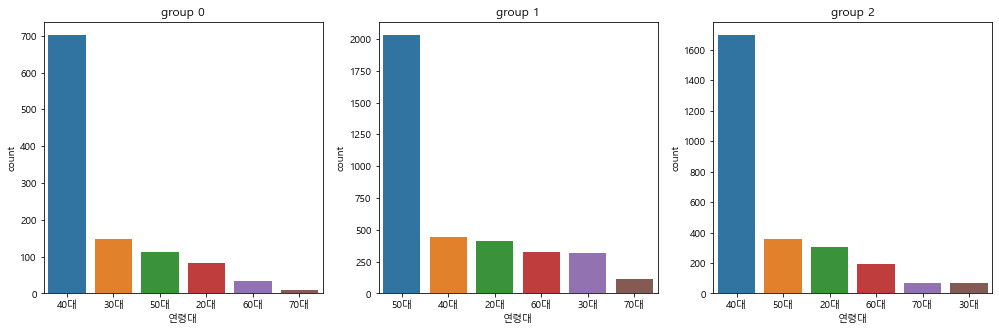

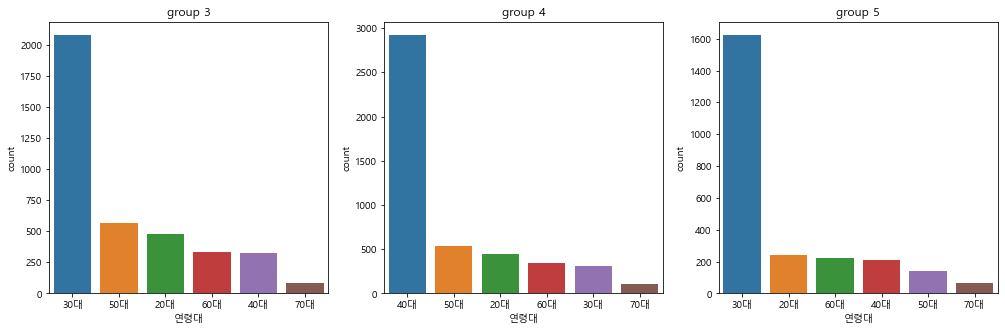

In [190]:
# 연령대
plt.figure(figsize=(17,5))
plt.subplot(131)
a=sns.countplot(x='연령대', data=cluster_0, order = cluster_0['연령대'].value_counts().index)
a.set(title = "group 0")
plt.subplot(132)
b=sns.countplot(x='연령대', data=cluster_1, order = cluster_1['연령대'].value_counts().index)
b.set(title = "group 1")
plt.subplot(133)
c=sns.countplot(x='연령대', data=cluster_2, order = cluster_2['연령대'].value_counts().index)
c.set(title = "group 2")
plt.show()

plt.figure(figsize=(17,5))
plt.subplot(131)
a=sns.countplot(x='연령대', data=cluster_3, order = cluster_3['연령대'].value_counts().index)
a.set(title = "group 3")
plt.subplot(132)
b=sns.countplot(x='연령대', data=cluster_4, order = cluster_4['연령대'].value_counts().index)
b.set(title = "group 4")
plt.subplot(133)
c=sns.countplot(x='연령대', data=cluster_5, order = cluster_5['연령대'].value_counts().index)
c.set(title = "group 5")
plt.show()

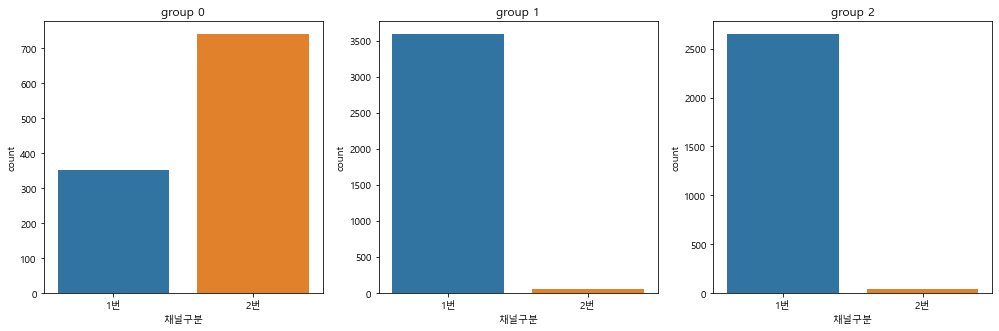

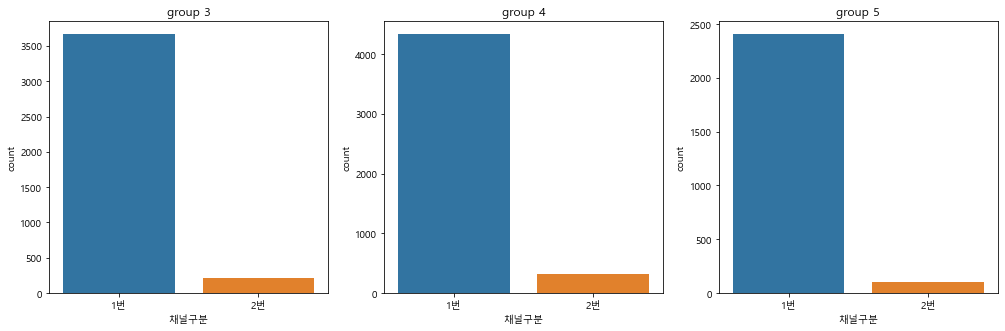

In [191]:
# 채널구분
plt.figure(figsize=(17,5))
plt.subplot(131)
a=sns.countplot(x='채널구분', data=cluster_0)
a.set(title = "group 0")
plt.subplot(132)
b=sns.countplot(x='채널구분', data=cluster_1)
b.set(title = "group 1")
plt.subplot(133)
c=sns.countplot(x='채널구분', data=cluster_2)
c.set(title = "group 2")
plt.show()

plt.figure(figsize=(17,5))
plt.subplot(131)
a=sns.countplot(x='채널구분', data=cluster_3)
a.set(title = "group 3")
plt.subplot(132)
b=sns.countplot(x='채널구분', data=cluster_4)
b.set(title = "group 4")
plt.subplot(133)
c=sns.countplot(x='채널구분', data=cluster_5)
c.set(title = "group 5")
plt.show()

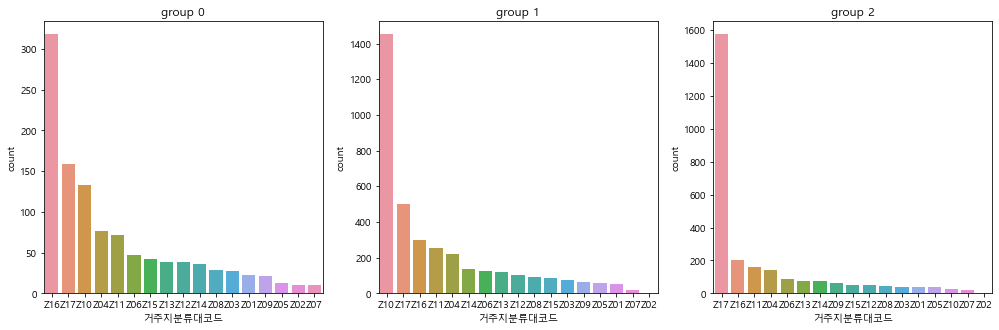

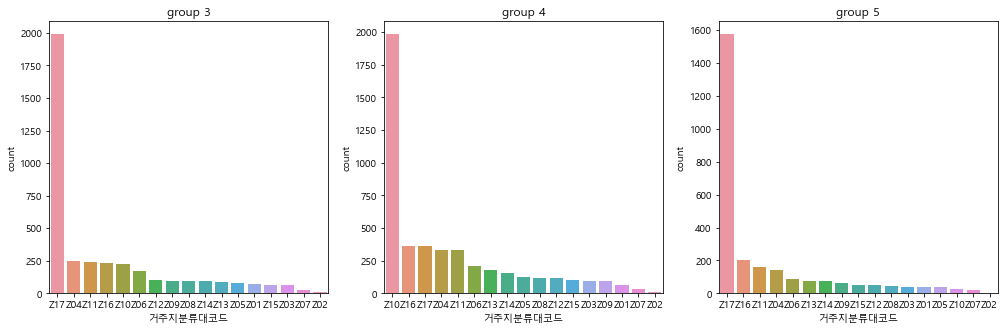

In [192]:
# 거주지분류대코드
plt.figure(figsize=(17,5))
plt.subplot(131)
a=sns.countplot(x='거주지분류대코드', data=cluster_0, order = cluster_0['거주지분류대코드'].value_counts().index)
a.set(title = "group 0")
plt.subplot(132)
b=sns.countplot(x='거주지분류대코드', data=cluster_1, order = cluster_1['거주지분류대코드'].value_counts().index)
b.set(title = "group 1")
plt.subplot(133)
c=sns.countplot(x='거주지분류대코드', data=cluster_2, order = cluster_2['거주지분류대코드'].value_counts().index)
c.set(title = "group 2")
plt.show()

plt.figure(figsize=(17,5))
plt.subplot(131)
a=sns.countplot(x='거주지분류대코드', data=cluster_3, order = cluster_3['거주지분류대코드'].value_counts().index)
a.set(title = "group 3")
plt.subplot(132)
b=sns.countplot(x='거주지분류대코드', data=cluster_4, order = cluster_4['거주지분류대코드'].value_counts().index)
b.set(title = "group 4")
plt.subplot(133)
c=sns.countplot(x='거주지분류대코드', data=cluster_2, order = cluster_2['거주지분류대코드'].value_counts().index)
c.set(title = "group 5")
plt.show()

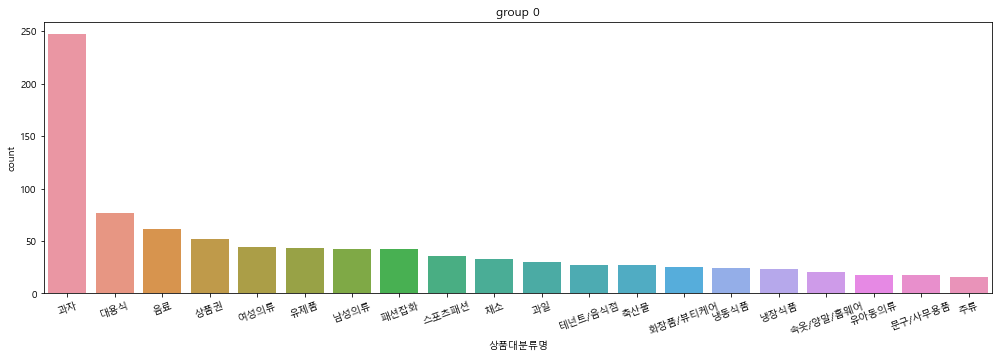

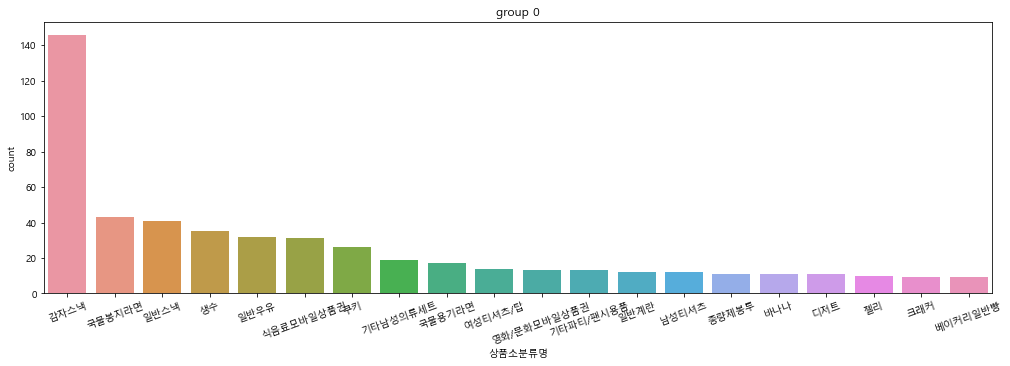

In [193]:
# 상품대분류명
plt.figure(figsize=(17,5))
a=sns.countplot(x='상품대분류명', data=cluster_0, order = cluster_0['상품대분류명'].value_counts().index[:20])
a.set_xticklabels(a.get_xticklabels(),rotation = 20)
a.set(title = "group 0")
plt.show()

# 상품소분류명
plt.figure(figsize=(17,5))
a=sns.countplot(x='상품소분류명', data=cluster_0, order = cluster_0['상품소분류명'].value_counts().index[:20])
a.set_xticklabels(a.get_xticklabels(),rotation = 20)
a.set(title = "group 0")
plt.show()

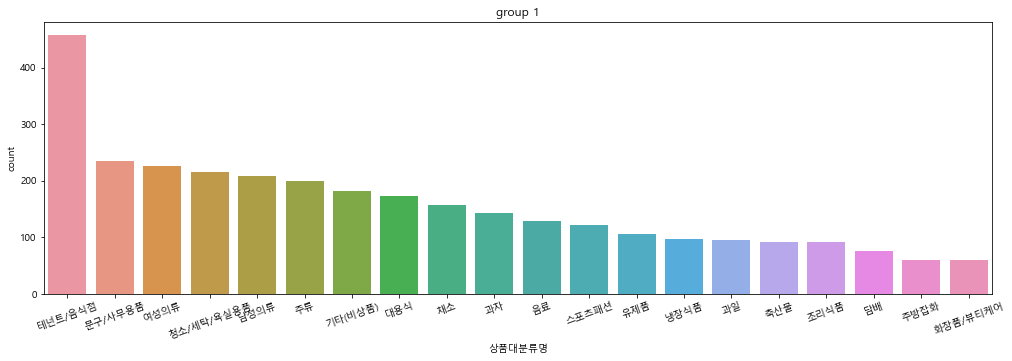

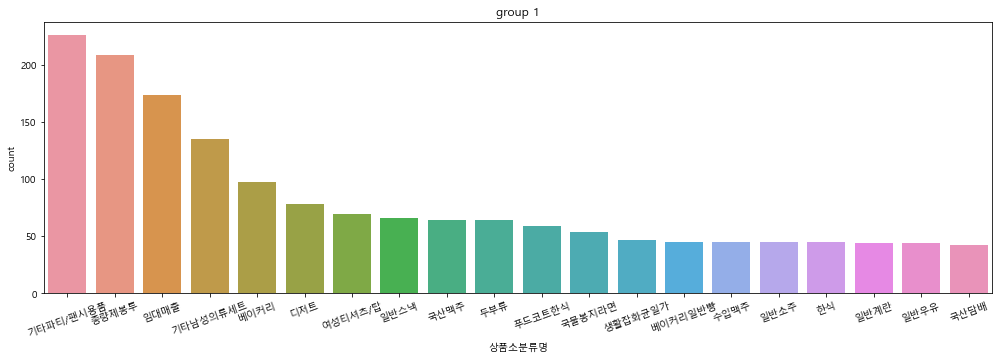

In [195]:
plt.figure(figsize=(17,5))
a=sns.countplot(x='상품대분류명', data=cluster_1, order = cluster_1['상품대분류명'].value_counts().index[:20])
a.set_xticklabels(a.get_xticklabels(),rotation = 20)
a.set(title = "group 1")
plt.show()

plt.figure(figsize=(17,5))
a=sns.countplot(x='상품소분류명', data=cluster_1, order = cluster_1['상품소분류명'].value_counts().index[:20])
a.set_xticklabels(a.get_xticklabels(),rotation = 20)
a.set(title = "group 1")
plt.show()

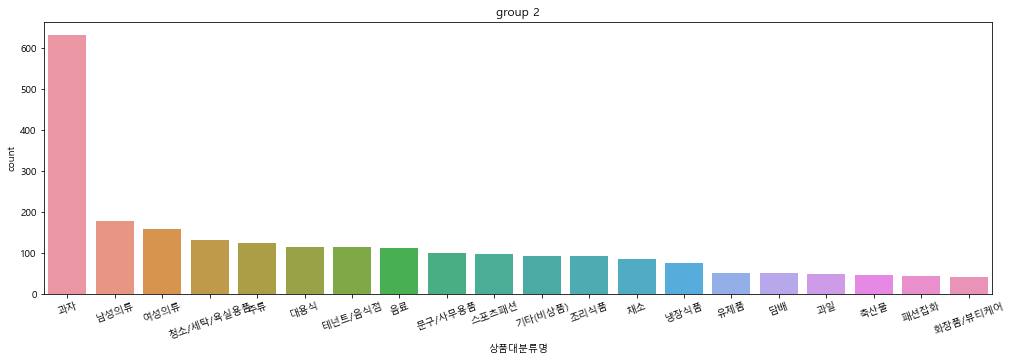

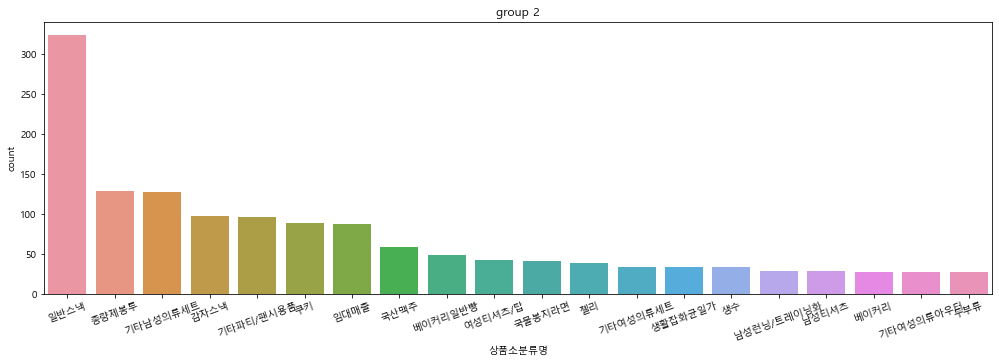

In [196]:
plt.figure(figsize=(17,5))
a=sns.countplot(x='상품대분류명', data=cluster_2, order = cluster_2['상품대분류명'].value_counts().index[:20])
a.set_xticklabels(a.get_xticklabels(),rotation = 20)
a.set(title = "group 2")
plt.show()

plt.figure(figsize=(17,5))
a=sns.countplot(x='상품소분류명', data=cluster_2, order = cluster_2['상품소분류명'].value_counts().index[:20])
a.set_xticklabels(a.get_xticklabels(),rotation = 20)
a.set(title = "group 2")
plt.show()

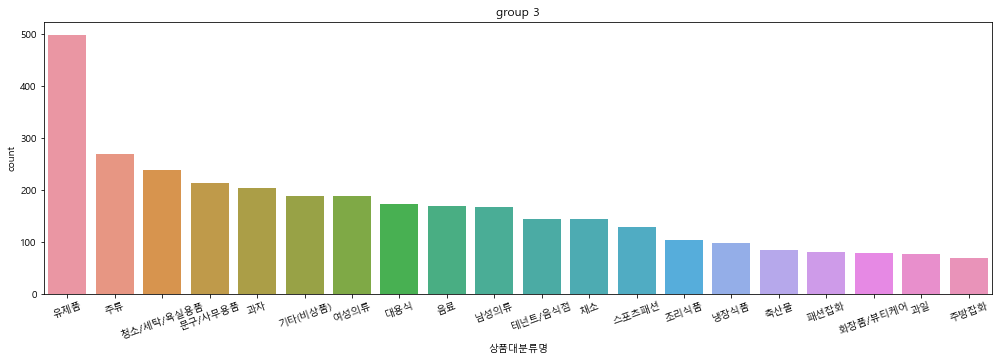

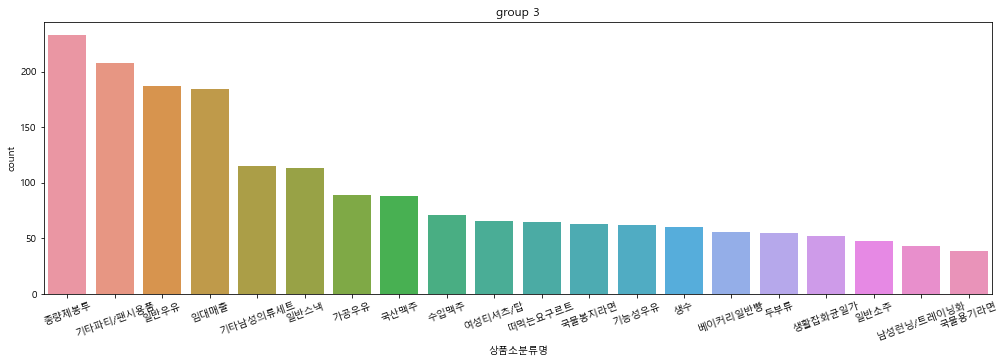

In [197]:
plt.figure(figsize=(17,5))
a=sns.countplot(x='상품대분류명', data=cluster_3, order = cluster_3['상품대분류명'].value_counts().index[:20])
a.set_xticklabels(a.get_xticklabels(),rotation = 20)
a.set(title = "group 3")
plt.show()

plt.figure(figsize=(17,5))
a=sns.countplot(x='상품소분류명', data=cluster_3, order = cluster_3['상품소분류명'].value_counts().index[:20])
a.set_xticklabels(a.get_xticklabels(),rotation = 20)
a.set(title = "group 3")
plt.show()

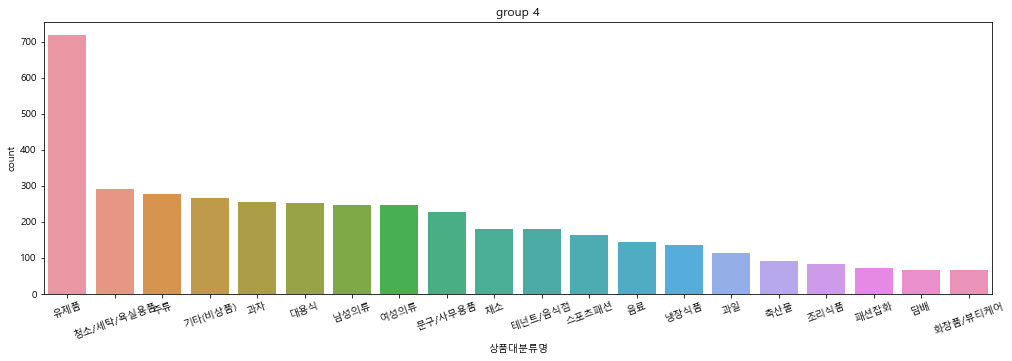

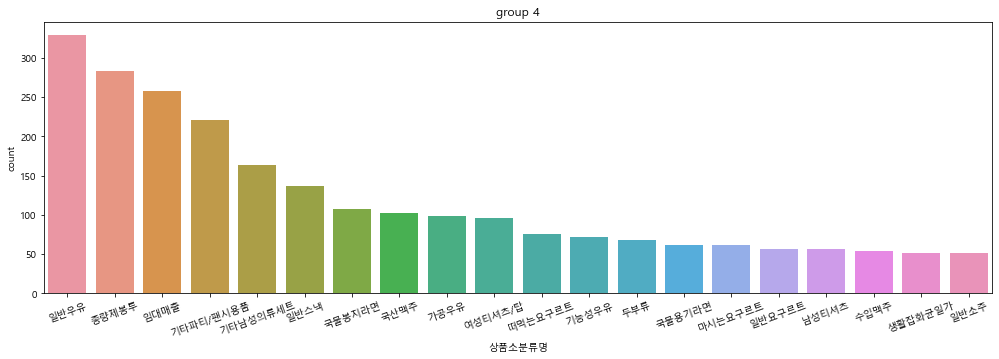

In [198]:
plt.figure(figsize=(17,5))
a=sns.countplot(x='상품대분류명', data=cluster_4, order = cluster_4['상품대분류명'].value_counts().index[:20])
a.set_xticklabels(a.get_xticklabels(),rotation = 20)
a.set(title = "group 4")
plt.show()

plt.figure(figsize=(17,5))
a=sns.countplot(x='상품소분류명', data=cluster_4, order = cluster_4['상품소분류명'].value_counts().index[:20])
a.set_xticklabels(a.get_xticklabels(),rotation = 20)
a.set(title = "group 4")
plt.show()

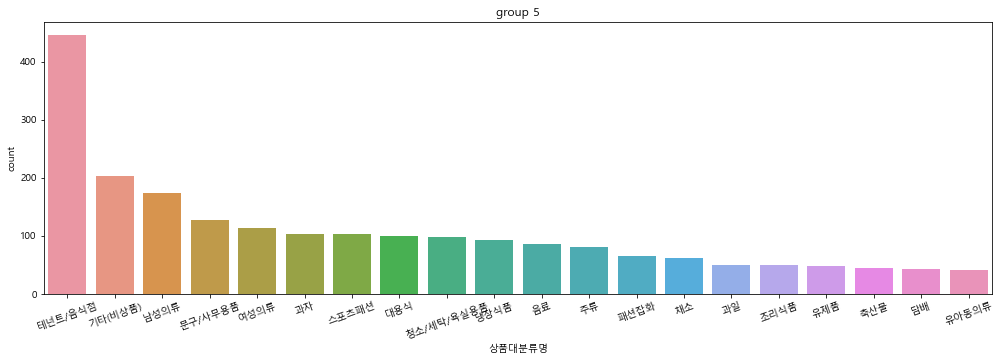

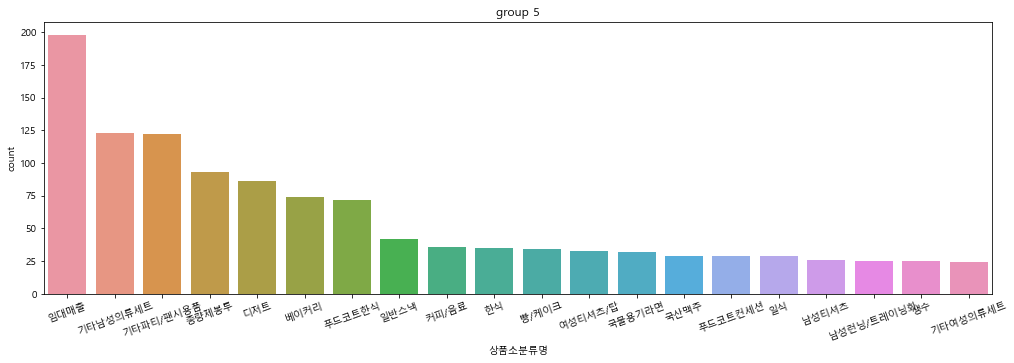

In [203]:
plt.figure(figsize=(17,5))
a=sns.countplot(x='상품대분류명', data=cluster_5, order = cluster_5['상품대분류명'].value_counts().index[:20])
a.set_xticklabels(a.get_xticklabels(),rotation = 20)
a.set(title = "group 5")
plt.show()

plt.figure(figsize=(17,5))
a=sns.countplot(x='상품소분류명', data=cluster_5, order = cluster_5['상품소분류명'].value_counts().index[:20])
a.set_xticklabels(a.get_xticklabels(),rotation = 20)
a.set(title = "group 5")
plt.show()

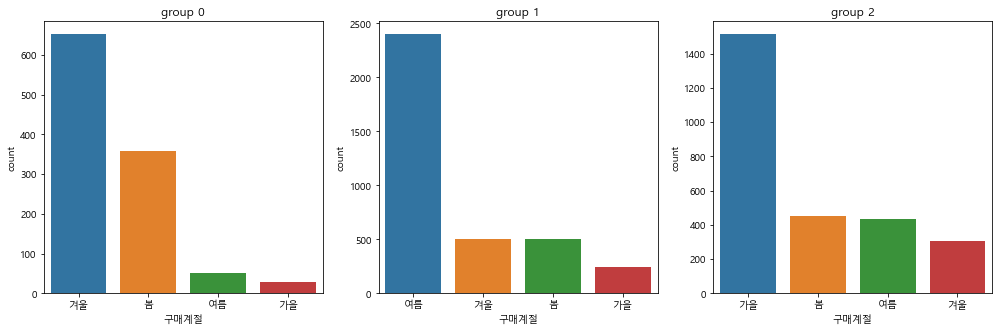

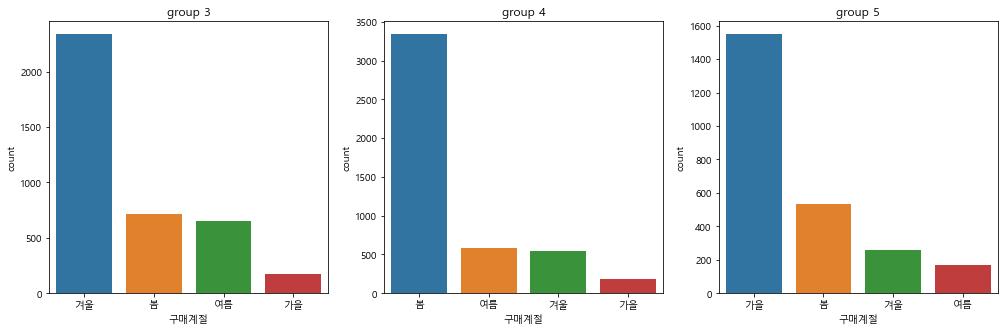

In [201]:
# 구매계절
plt.figure(figsize=(17,5))
plt.subplot(131)
a=sns.countplot(x='구매계절', data=cluster_0, order = cluster_0['구매계절'].value_counts().index)
a.set(title = "group 0")
plt.subplot(132)
b=sns.countplot(x='구매계절', data=cluster_1, order = cluster_1['구매계절'].value_counts().index)
b.set(title = "group 1")
plt.subplot(133)
c=sns.countplot(x='구매계절', data=cluster_2, order = cluster_2['구매계절'].value_counts().index)
c.set(title = "group 2")
plt.show()

plt.figure(figsize=(17,5))
plt.subplot(131)
a=sns.countplot(x='구매계절', data=cluster_3, order = cluster_3['구매계절'].value_counts().index)
a.set(title = "group 3")
plt.subplot(132)
b=sns.countplot(x='구매계절', data=cluster_4, order = cluster_4['구매계절'].value_counts().index)
b.set(title = "group 4")
plt.subplot(133)
c=sns.countplot(x='구매계절', data=cluster_5, order = cluster_5['구매계절'].value_counts().index)
c.set(title = "group 5")
plt.show()

수치형 변수 확인해보기

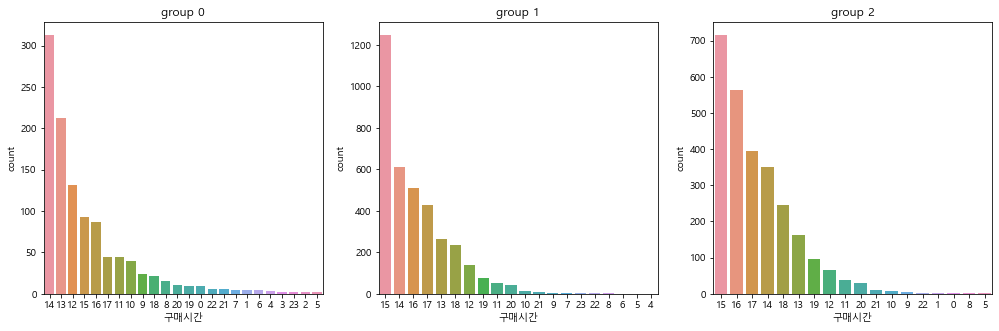

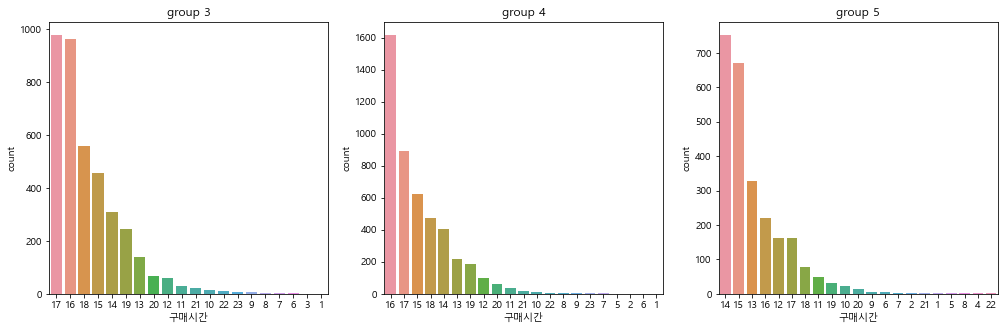

In [202]:
# 구매시간
plt.figure(figsize=(17,5))
plt.subplot(131)
a=sns.countplot(x='구매시간', data=cluster_0, order = cluster_0['구매시간'].value_counts().index)
a.set(title = "group 0")
plt.subplot(132)
b=sns.countplot(x='구매시간', data=cluster_1, order = cluster_1['구매시간'].value_counts().index)
b.set(title = "group 1")
plt.subplot(133)
c=sns.countplot(x='구매시간', data=cluster_2, order = cluster_2['구매시간'].value_counts().index)
c.set(title = "group 2")
plt.show()

plt.figure(figsize=(17,5))
plt.subplot(131)
a=sns.countplot(x='구매시간', data=cluster_3, order = cluster_3['구매시간'].value_counts().index)
a.set(title = "group 3")
plt.subplot(132)
b=sns.countplot(x='구매시간', data=cluster_4, order = cluster_4['구매시간'].value_counts().index)
b.set(title = "group 4")
plt.subplot(133)
c=sns.countplot(x='구매시간', data=cluster_5, order = cluster_5['구매시간'].value_counts().index)
c.set(title = "group 5")
plt.show()

In [284]:
a = pd.crosstab(ndf2['상품대분류명'], ndf2['거주지분류대코드'], margins=True)

In [285]:
pd.set_option('display.max_rows', None)

In [295]:
pd.crosstab(ndf2[ndf2['거주지분류대코드'] == 'Z10']['상품대분류명'], ndf2[ndf2['거주지분류대코드'] == 'Z10']['거주지분류대코드'], None)

거주지분류대코드,Z10
상품대분류명,
가구,7
건강식품,18
건강용품,10
건해산물,8
계절가전,8
공구/안전용품,5
과일,106
과자,365
구기/필드스포츠,10
